# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from minisom import MiniSom

from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [2]:
np.random.seed(42)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/01c_minisom'

# Loading data

In [4]:
path_to_data = './../data/ftir_scaled_train.csv'
path_to_description = './../data/ftir_description.csv'

## Scaled spectra

In [5]:
data_scaled = pd.read_csv(path_to_data, index_col=0)

print(data_scaled.shape)
data_scaled.head(3)

(26, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,...,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


## Samples description

In [6]:
samples_description = pd.read_csv(path_to_description, index_col=0)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Data wrangling

In [7]:
samples_description = (
    samples_description
    .loc[samples_description['Label'] == 'Train']
    .drop(columns=['Label'])
)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(25, 3)


,Description,Type,Class
1,"MFGO, разб. 1:20",$GO$,1
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1


In [8]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

In [9]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

# Clustering using *MiniSom*

## Class for clustering

In [11]:
class SomStructureAnalysis():
    def __init__(self, data):
        if type(data) is pd.core.frame.DataFrame:
            self.train_data = data.to_numpy()
        elif type(data) is list:
            self.train_data = np.array(data)
        else:
            self.train_data = data
        
    def fit_transform_som(self, shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=10_000, random_seed=42, verbose=True):
        train_data = self.train_data
        estimator = MiniSom(x=shape[0],
                            y=shape[1],
                            input_len=train_data.shape[1],
                            sigma=sigma,
                            learning_rate=learning_rate,
                            neighborhood_function='gaussian',
                            random_seed=random_seed)
        
        estimator.train_batch(data=train_data, num_iteration=num_iteration, verbose=verbose)

        winner_coordinates = np.array([estimator.winner(x) for x in train_data]).T
        predictions = np.ravel_multi_index(winner_coordinates, shape)

        data_with_predictions = pd.DataFrame(train_data)
        data_with_predictions['Prediction'] = predictions

        cluster_centers = data_with_predictions.groupby(['Prediction']).agg('mean').reset_index().iloc[:, 1:].to_numpy()

        self.n_clusters = int(shape[0] * shape[1])
        self.estimator = estimator
        self.predictions = predictions
        self.train_data_predictions = data_with_predictions
        self.cluster_centers = cluster_centers
    
    def get_silhouette_score(self):
        train_data = self.train_data
        predictions = self.predictions
        if self.n_clusters >= 2:
            silhouette = silhouette_score(train_data, predictions)
        else:
            silhouette = None
        return silhouette

    def get_metric_in_range(self, metric='silhouette', num_iteration=2_000, max_n_clusters=None):
        train_data = self.train_data
        if max_n_clusters is None:
            max_n_clusters = train_data.shape[0] - 1
        shapes_arr = range(1, max_n_clusters+1)

        metric_values = []
        shape_values = []
        
        for shape1 in tqdm(shapes_arr):
            for shape2 in shapes_arr:
                if (shape1 * shape2 >= 2) and (shape1 * shape2 <= max_n_clusters):
                    n_clusters = shape1 * shape2
                else:
                    continue
                self.fit_transform_som(shape=(shape1, shape2), num_iteration=num_iteration, verbose=False)
                if metric == 'silhouette':
                    value = self.get_silhouette_score()
                metric_values.append(value)
                shape_values.append(f'({shape1}; {shape2})')
        return metric_values, shape_values

    def get_metrics_visualization(self, metric='silhouette', num_iteration=1_000, max_n_clusters=None, figsize=(11, 7.5), rotation_x=0, path_to_save=None, dpi=300):
        if max_n_clusters is None:
            max_n_clusters = self.train_data.shape[0] - 1
    
        if metric == 'silhouette':
            metric_values, shape_of_grid_arr = self.get_metric_in_range(metric='silhouette', num_iteration=num_iteration, max_n_clusters=max_n_clusters)
        elif metric == 'inertia':
            metric_values, shape_of_grid_arr = self.get_metric_in_range(metric='inertia', num_iteration=num_iteration, max_n_clusters=max_n_clusters)

        qm_df_vis = pd.DataFrame(
            {
            'Shape of grid': shape_of_grid_arr,
            'Value': metric_values
            }
        )

        # qm_df_vis = qm_df_vis.sort_values(by='Value', ascending=False)
        
        sns.set_theme()

        fig = plt.figure(figsize=figsize, dpi=600, linewidth=1.0)
        
        ax = fig.gca()
        
        ax.grid(True)
        ax.tick_params(direction='in')
        
        bar = sns.barplot(data=qm_df_vis,
                          x='Shape of grid',
                          y='Value',
                          palette='viridis',
                          ax=ax)

        ax.set_ylabel('Silhouette score',
                      fontstyle='normal',
                      fontsize=16,
                      rotation=90,
                      labelpad=5)
        
        ax.set_xlabel('Shape of grid',
                      fontstyle='normal',
                      fontsize=16,
                      rotation=0,
                      labelpad=5)
        
        bar.set_xticklabels(bar.get_xticklabels(), rotation=rotation_x, fontsize=12)
        bar.set_yticklabels(bar.get_yticklabels(), rotation=rotation_x, fontsize=12)
        
        plt.tight_layout()

        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

    def get_spectra_clusters_visualization(self, shape, wavenumber, nrows, ncols, num_iteration=10_000, figsize=(10, 6), color='dodgerblue', path_to_save=None, dpi=300):
        self.fit_transform_som(shape=shape, num_iteration=num_iteration)
        data_with_labels = self.train_data_predictions
        centroids = self.cluster_centers

        n_clusters = int(shape[0] * shape[1])

        fig = plt.figure(figsize=figsize, dpi=600)
        
        for i in range(len(centroids)):
            temp_data = data_with_labels.loc[data_with_labels['Prediction'] == i].iloc[:, :-1].to_numpy()
            temp_centroid = centroids[i]
        
            ax = plt.subplot(nrows, ncols, i+1)
            
            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=2.5, color=color)
        
            ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=2.5, color='black')
        
            ax.set_xlabel('Wavenumber, cm$^{-1}$', fontstyle='normal', fontsize=14, labelpad=5)
            ax.set_ylabel('$A_{n}$', fontstyle='italic', fontsize=14, labelpad=15, rotation=0)

            ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
        
            ax.invert_xaxis()
        
        plt.tight_layout()
        
        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

In [14]:
FONT_SIZE_TITLE = 22
FONT_SIZE_XLABEL = 18
FONT_SIZE_YLABEL = 18
FONT_SIZE_XTICKS = 16
FONT_SIZE_YTICKS = 16

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.8206321598726972


Computing silhouette values: 100%|██████████████| 10/10 [00:13<00:00,  1.35s/it]


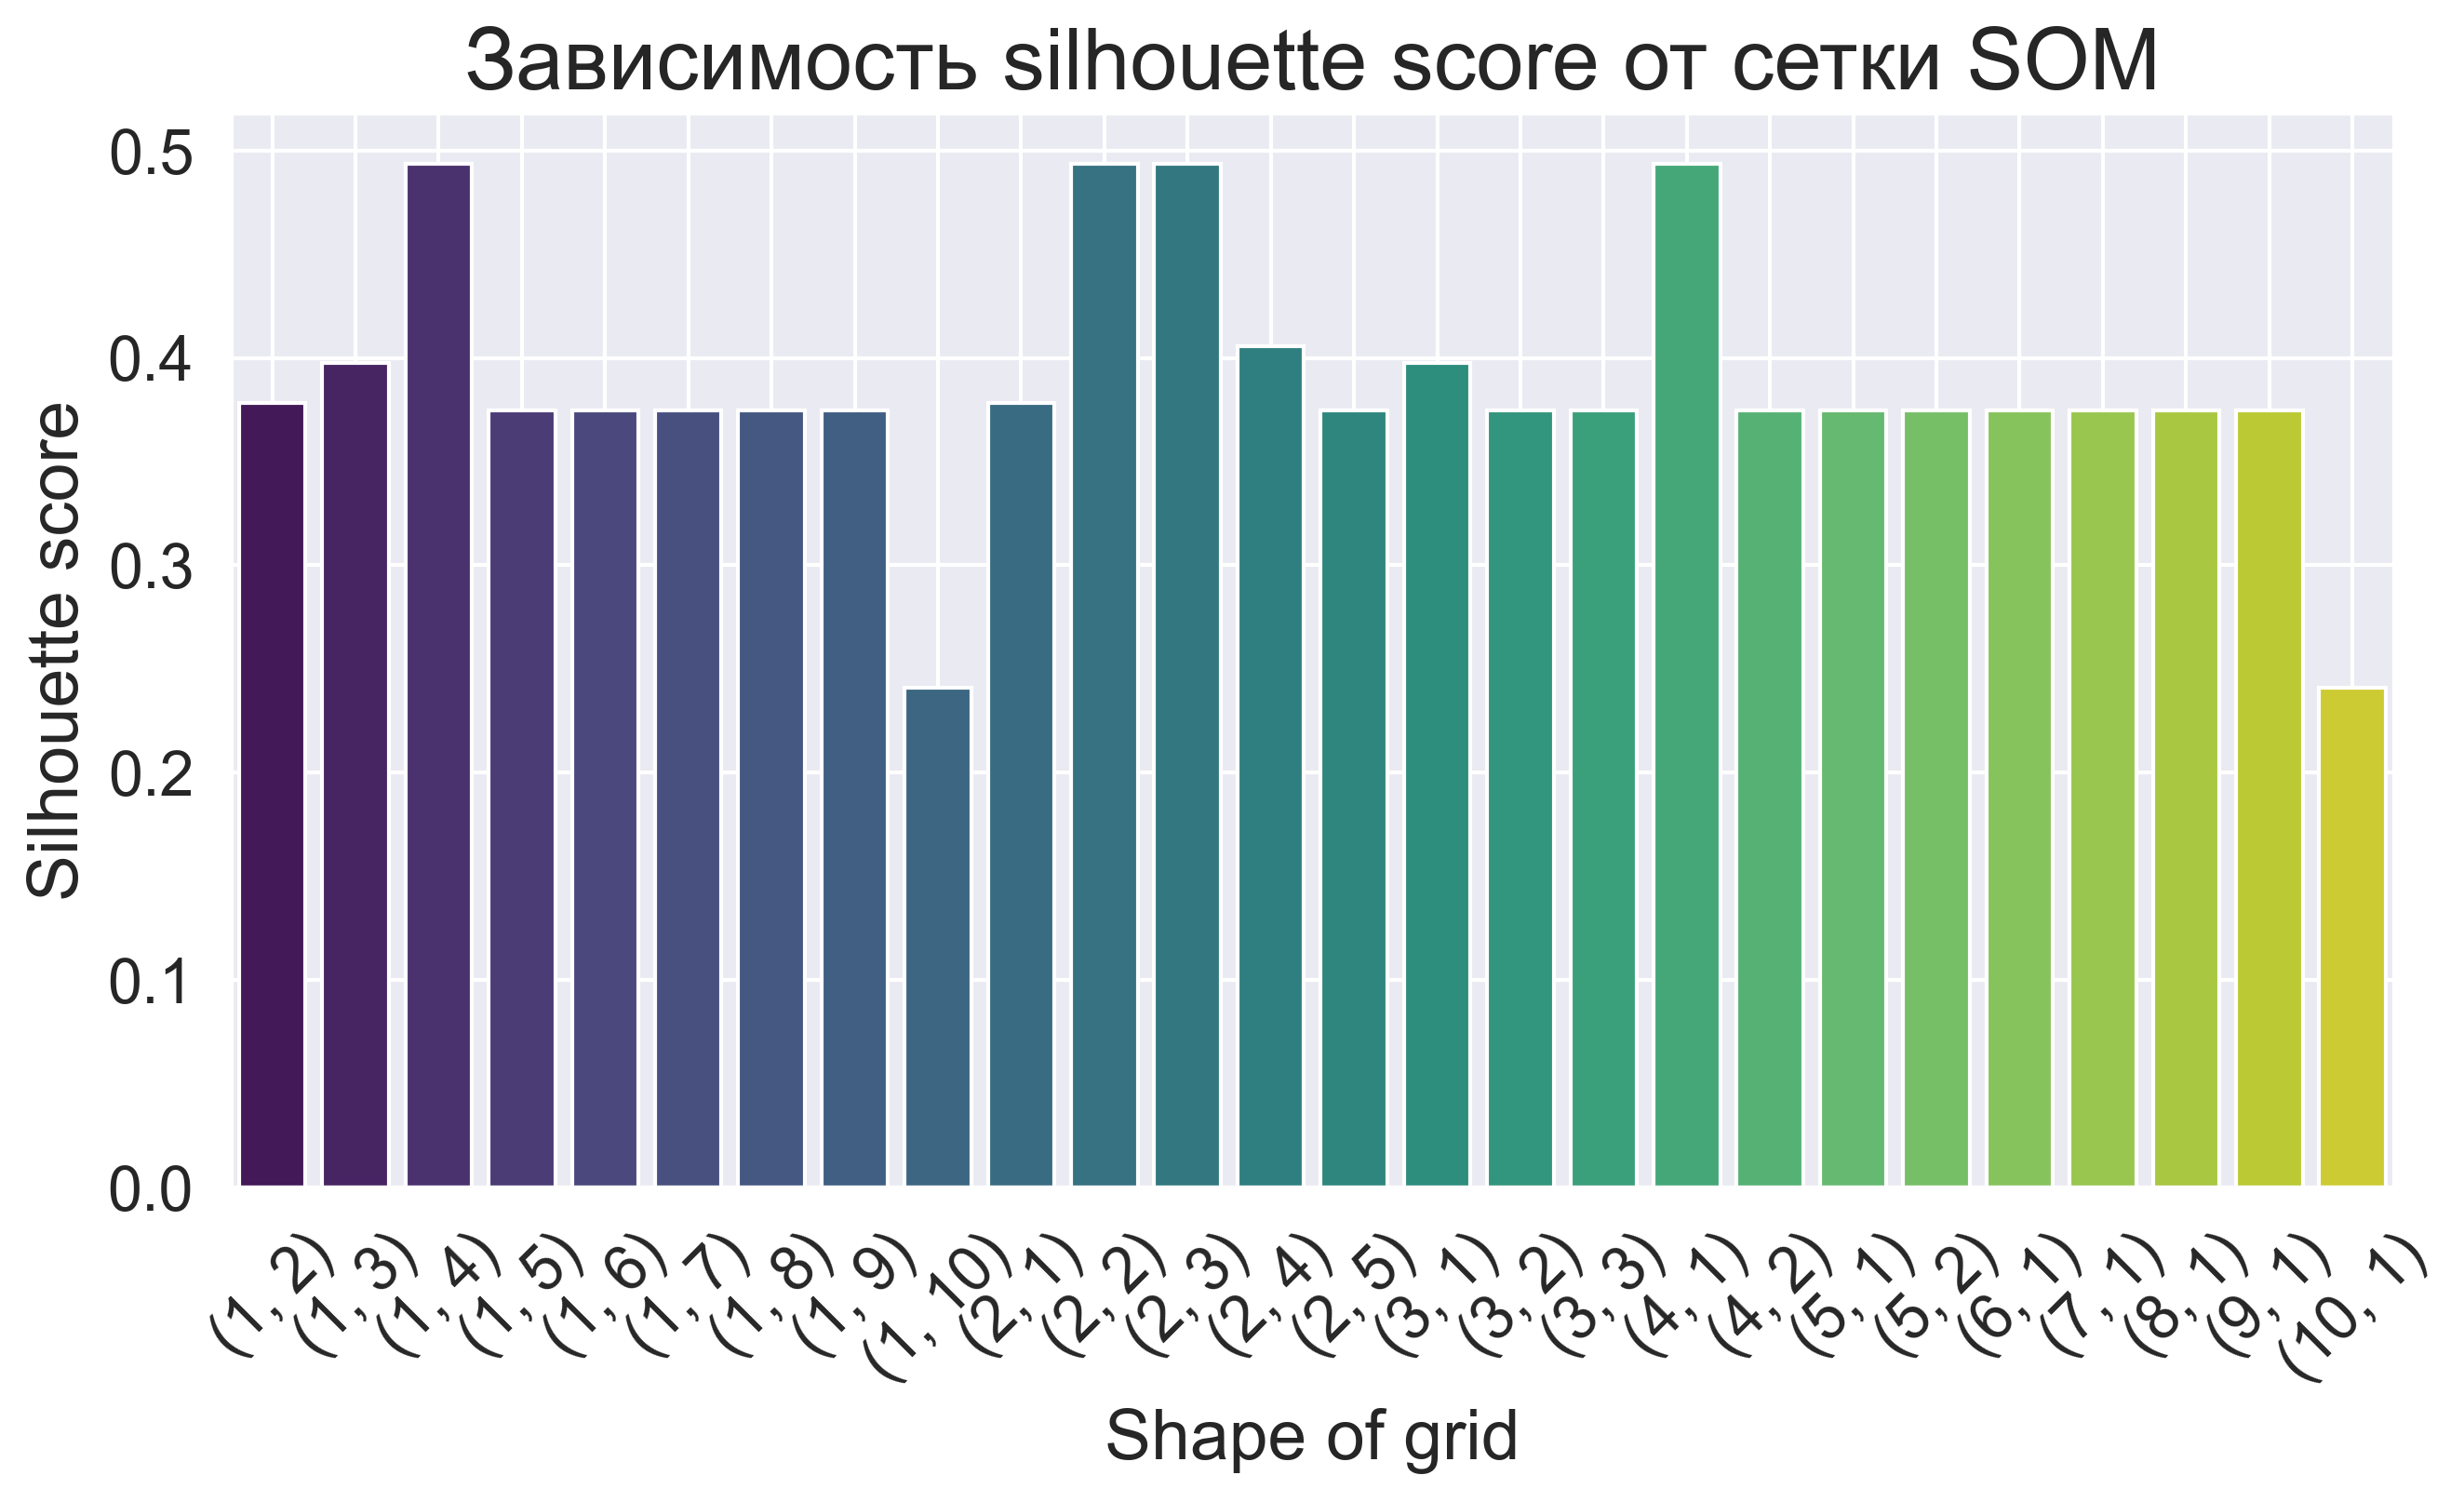

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8206322570355252


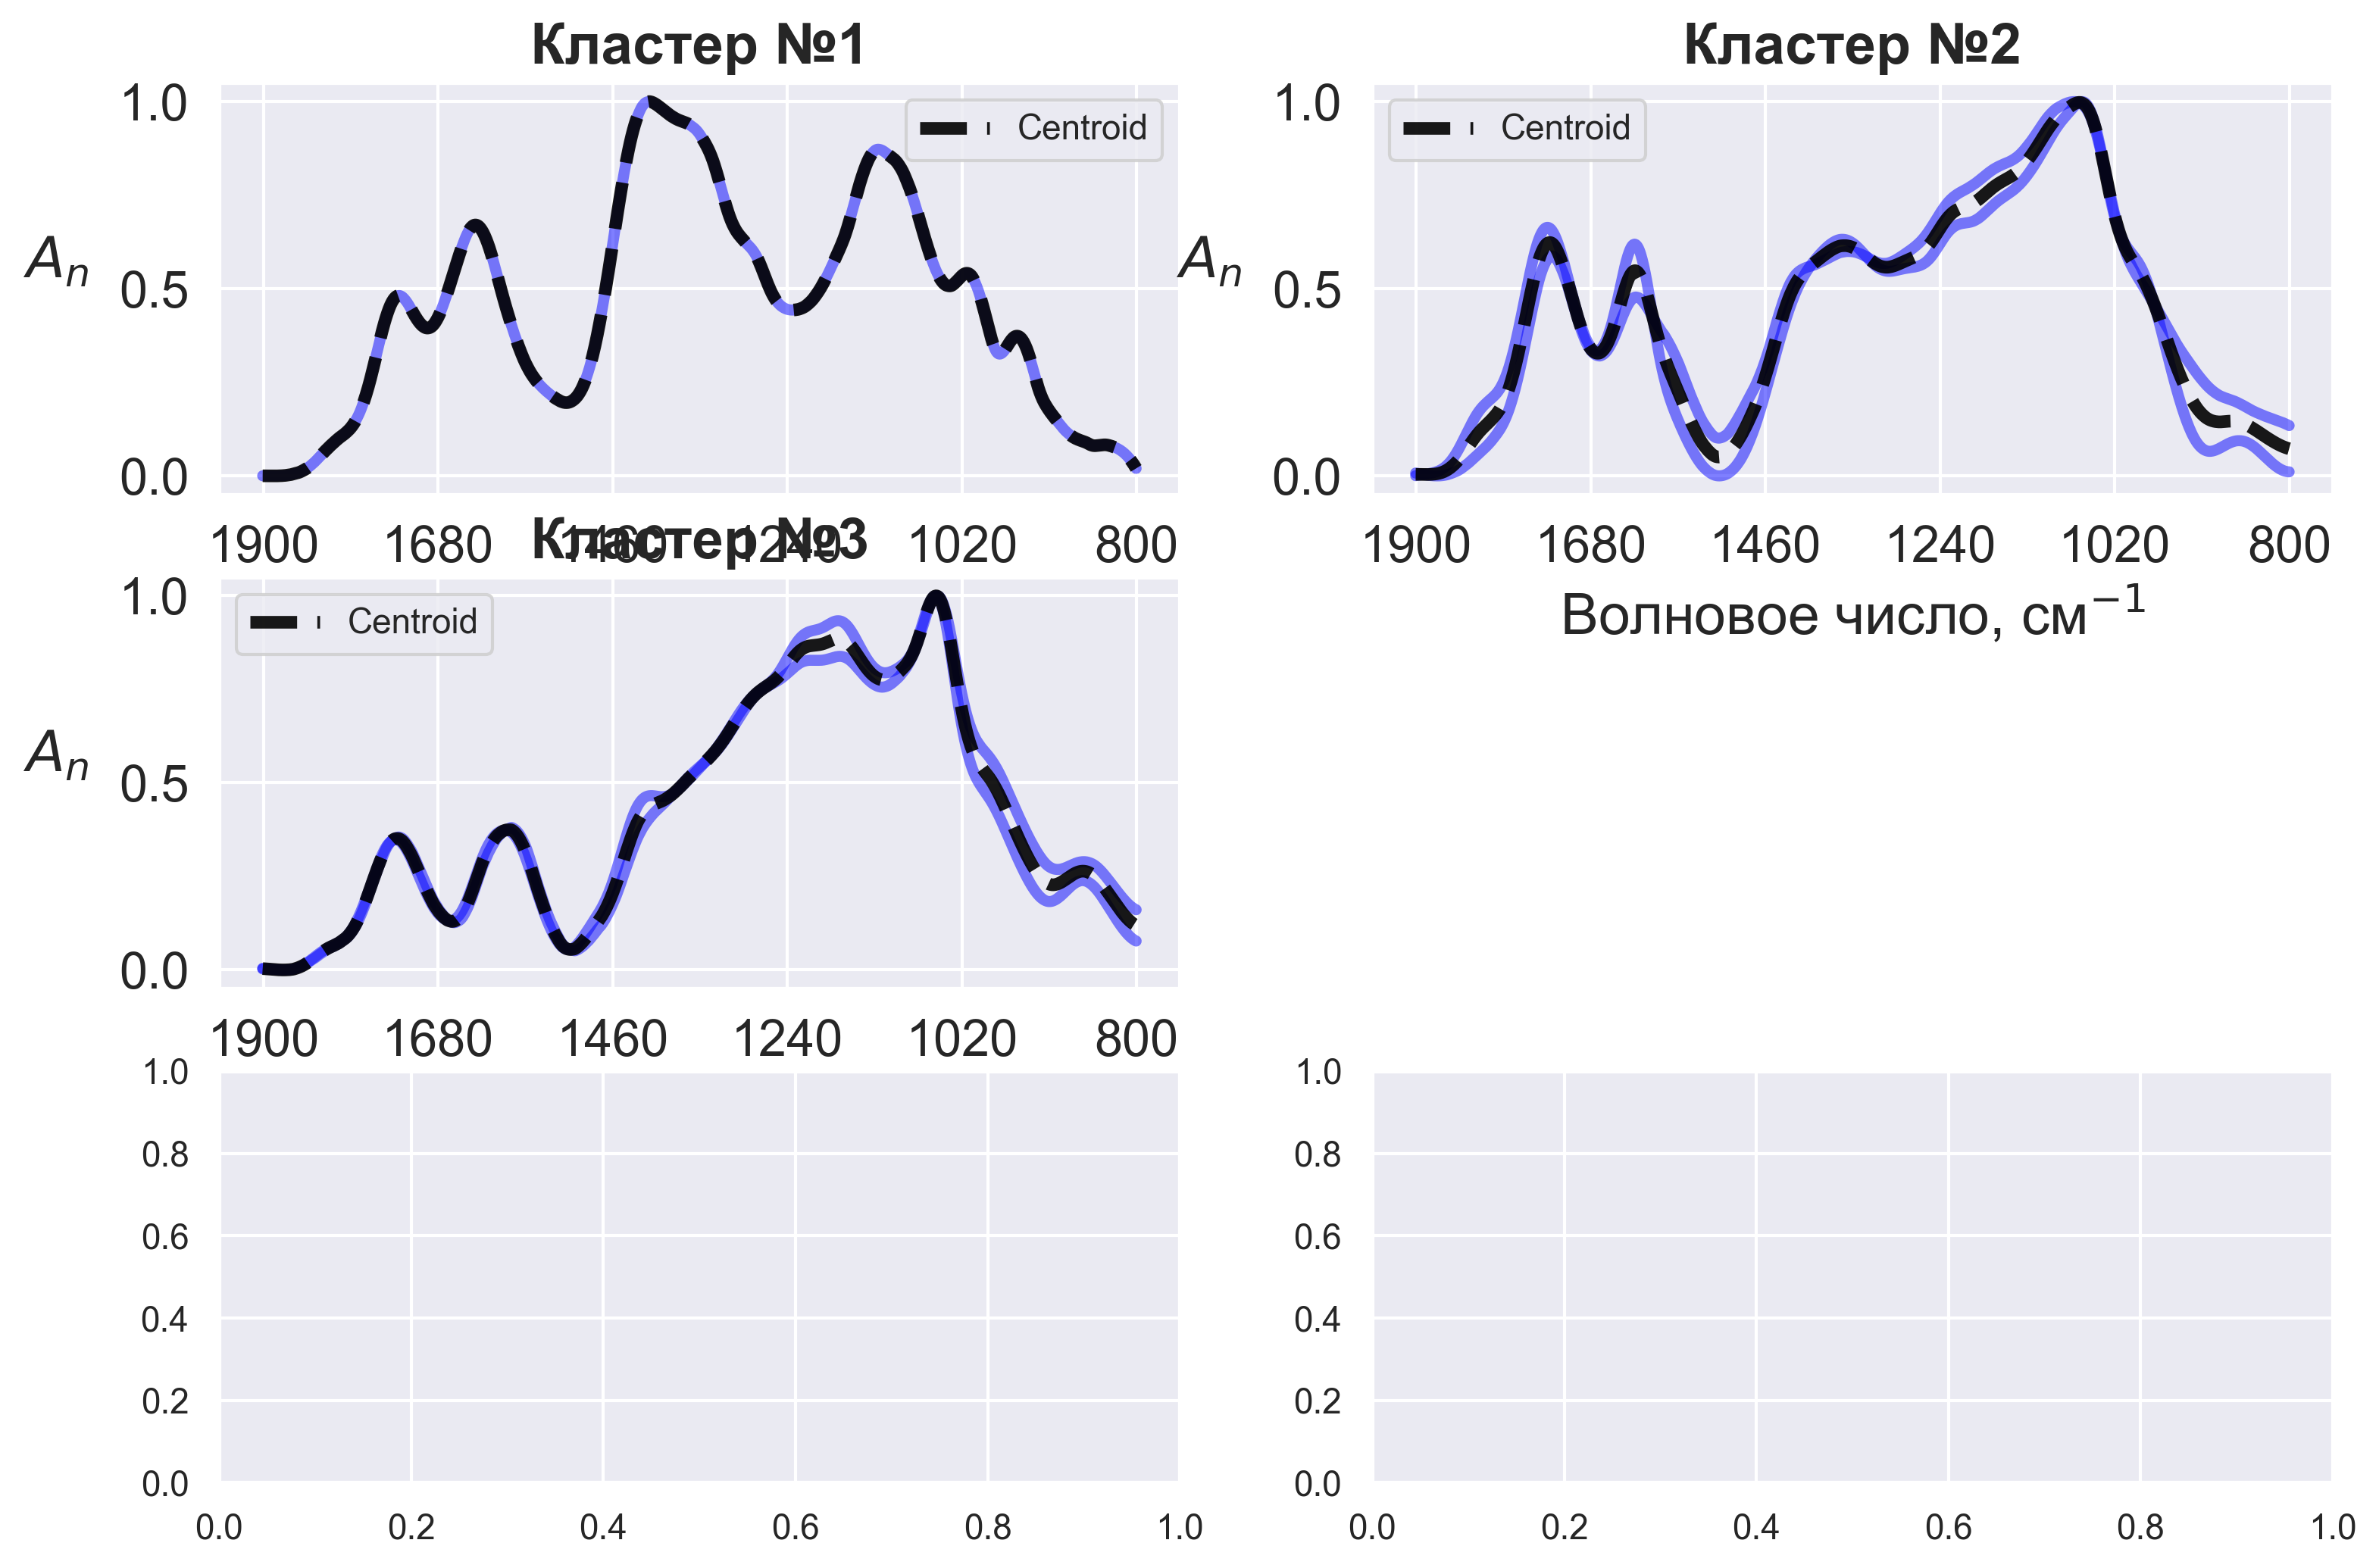

In [18]:
from minisom import MiniSom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import silhouette_score


class SomStructureAnalysis:
    def __init__(self, data):
        if isinstance(data, pd.DataFrame):
            self.train_data = data.to_numpy()
            self.original_data = data
        elif isinstance(data, list):
            self.train_data = np.array(data)
            self.original_data = pd.DataFrame(data)
        else:
            self.train_data = data
            self.original_data = pd.DataFrame(data)

    def fit_transform_som(self, shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=10_000, random_seed=42, verbose=True):
        train_data = self.train_data
        estimator = MiniSom(
            x=shape[0], y=shape[1], input_len=train_data.shape[1],
            sigma=sigma, learning_rate=learning_rate, neighborhood_function='gaussian',
            random_seed=random_seed
        )

        if num_iteration < len(train_data):
            estimator.train_random(train_data, num_iteration, verbose=verbose)
        else:
            estimator.train_batch(train_data, num_iteration, verbose=verbose)

        winner_coordinates = np.array([estimator.winner(x) for x in train_data]).T
        predictions = np.ravel_multi_index(winner_coordinates, shape)

        data_with_predictions = self.original_data.copy()
        data_with_predictions['Prediction'] = predictions

        self.n_clusters = len(set(predictions))
        self.estimator = estimator
        self.predictions = predictions
        self.train_data_predictions = data_with_predictions.sort_values(by='Prediction')

        # 🔹 Центроиды из original_data, а не из эмбеддингов
        self.cluster_centers = self.train_data_predictions.groupby(['Prediction']).mean().to_numpy()

    def get_silhouette_score(self):
        if self.n_clusters >= 2:
            return silhouette_score(self.train_data, self.predictions)
        return None

    def get_metrics_visualization(self, max_n_clusters, ax, metric='silhouette', num_iteration=2_000, refit=False):
        shapes_arr = range(1, max_n_clusters + 1)
        metric_values, shape_values = [], []
        original_n_clusters = self.n_clusters  # Сохраняем текущее число кластеров

        for shape1 in tqdm(shapes_arr, desc=f'Computing {metric} values'):
            for shape2 in shapes_arr:
                if shape1 * shape2 >= 2 and shape1 * shape2 <= max_n_clusters:
                    self.fit_transform_som(shape=(shape1, shape2), num_iteration=num_iteration, verbose=False)
                    value = self.get_silhouette_score() if metric == 'silhouette' else None
                    metric_values.append(value)
                    shape_values.append(f'({shape1}, {shape2})')

        sns.barplot(x=shape_values, y=metric_values, palette='viridis', ax=ax)
        ax.set_title('Зависимость silhouette score от сетки SOM', fontsize=FONT_SIZE_TITLE)
        ax.set_xlabel('Shape of grid', fontsize=FONT_SIZE_XLABEL)
        ax.set_ylabel('Silhouette score', fontsize=FONT_SIZE_YLABEL)
        ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS, rotation=45)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)
        ax.grid(True)

        if not refit:
            self.fit_transform_som(shape=(1, original_n_clusters), num_iteration=num_iteration, verbose=False)

    def get_spectra_clusters_visualization(self, shape, wavenumber, axes, color, num_iteration=10_000):
        self.fit_transform_som(shape=shape, num_iteration=num_iteration)
        data_with_labels = self.train_data_predictions
        n_clusters = self.n_clusters

        for cluster_id in range(n_clusters):
            ax = axes[cluster_id]

            temp_data = data_with_labels[data_with_labels['Prediction'] == cluster_id].iloc[:, :-1].to_numpy()
            temp_centroid = np.mean(temp_data, axis=0) if len(temp_data) > 0 else None

            if len(temp_data) == 0:
                ax.axis("off")
                continue

            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=3.5, color=color, alpha=0.5)

            if temp_centroid is not None:
                ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=4.0, color='black', alpha=0.9, label='Centroid')

            ax.set_title(f'Кластер №{cluster_id+1}', fontsize=FONT_SIZE_TITLE-4, fontweight='bold')
            ax.set_xlabel('Волновое число, см$^{-1}$', fontsize=FONT_SIZE_XLABEL)
            ax.set_ylabel('$A_{n}$', fontsize=FONT_SIZE_YLABEL, rotation=0, labelpad=20)
            ax.set_xticks(np.linspace(1900, 800, 6))
            ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS)
            ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)
            ax.invert_xaxis()
            ax.legend()


# 🔹 Пример использования:
max_n_clusters = 10
som_analyzer = SomStructureAnalysis(go_data)

# 🔹 Кластеризуем
som_analyzer.fit_transform_som(shape=(2, 3), num_iteration=50_000)

# 🔹 Визуализация метрик
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
som_analyzer.get_metrics_visualization(max_n_clusters=10, ax=ax, metric='silhouette', refit=False)
plt.show()

# 🔹 Визуализация спектров по кластерам
fig, axes = plt.subplots(3, 2, figsize=(12, 8), dpi=300)
som_analyzer.get_spectra_clusters_visualization(shape=(2, 3), wavenumber=wavenumber, axes=axes.flatten(), color='blue')
plt.show()


## Clustering

### *GO*

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.431250817259689


100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.69it/s]


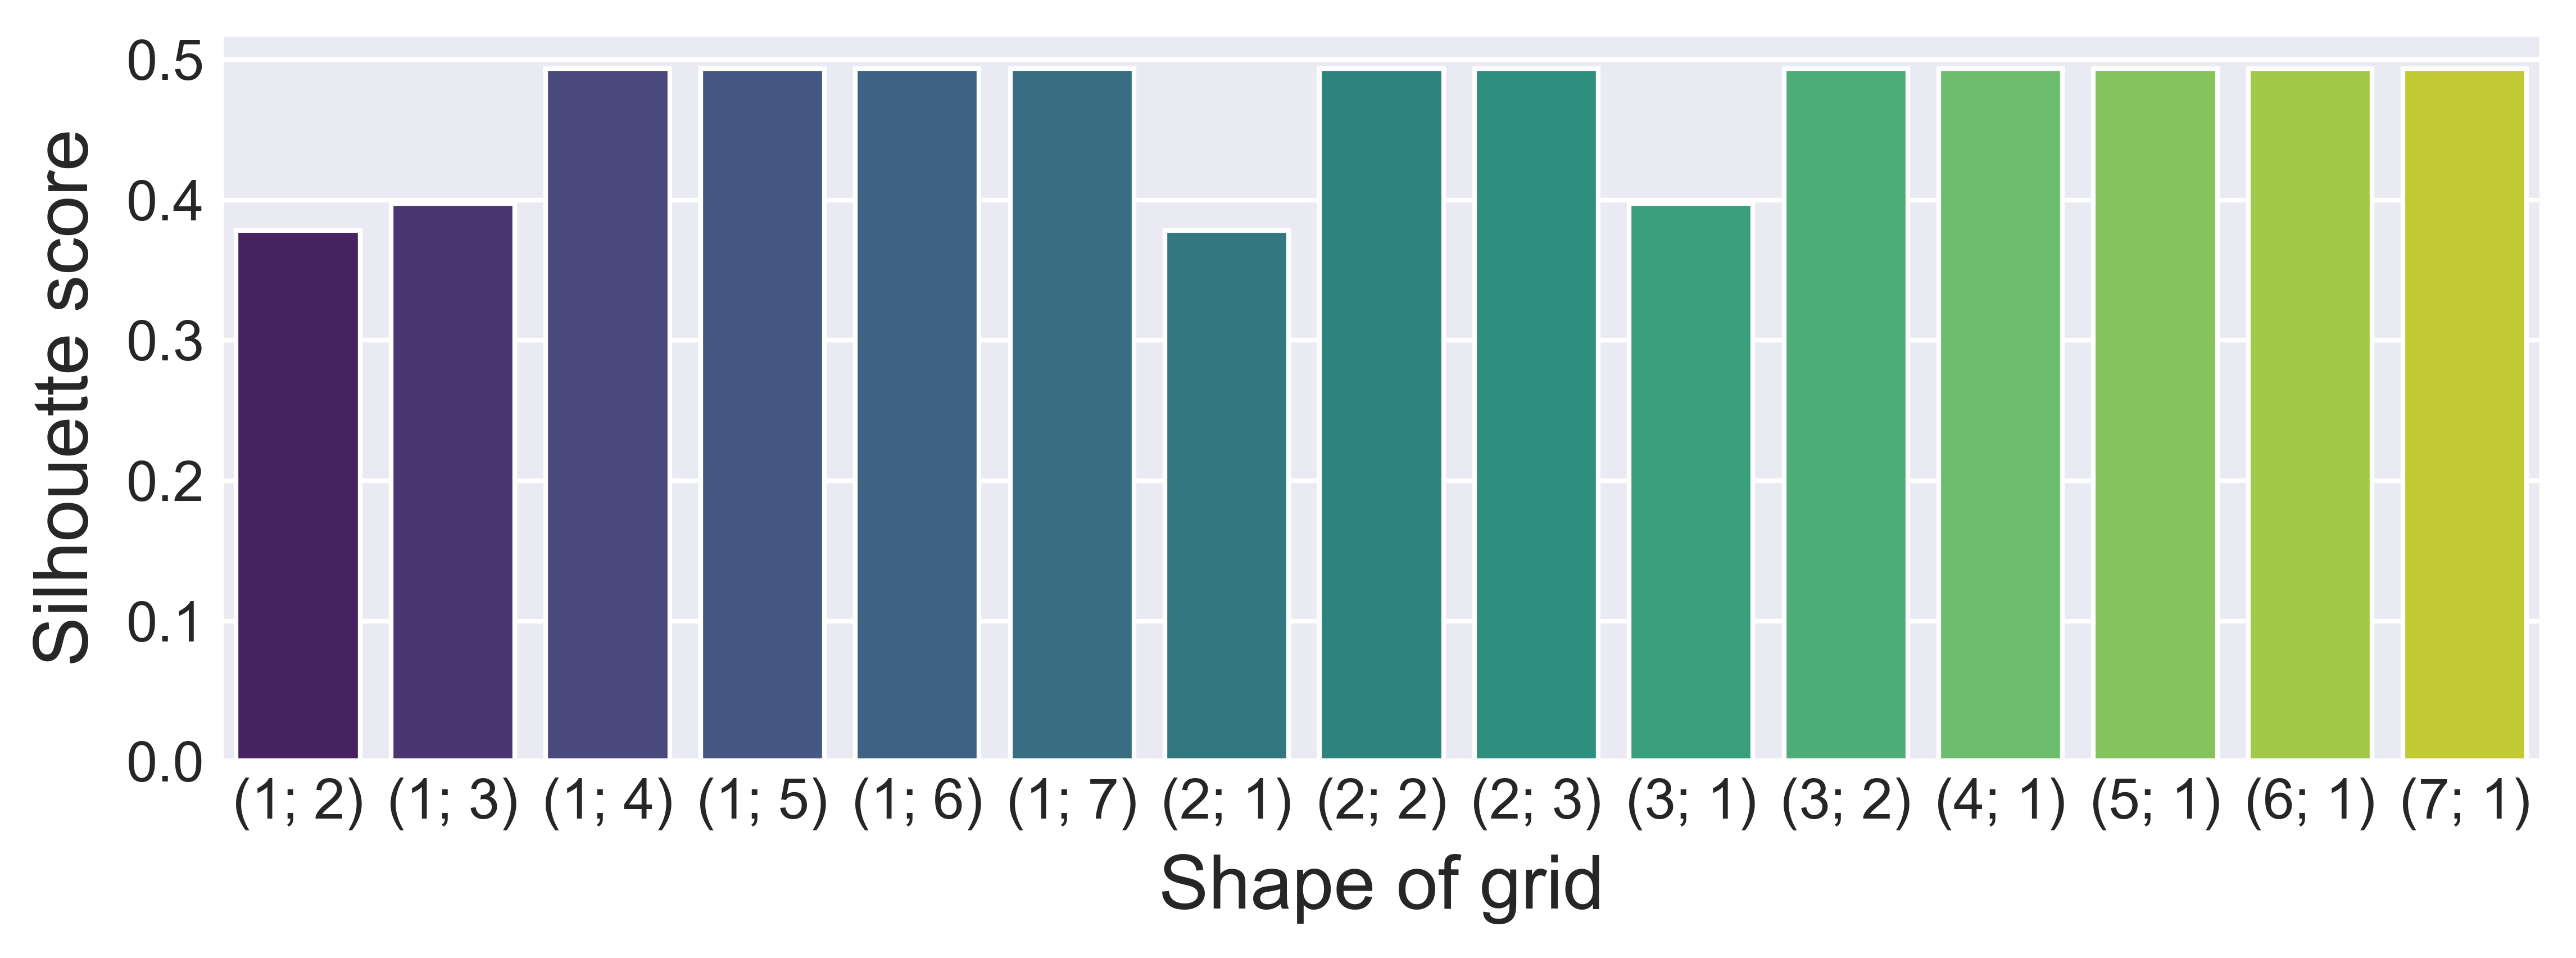

In [12]:
test_an = SomStructureAnalysis(go_data)
test_an.fit_transform_som(shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=1_000, random_seed=42)

test_an.get_metrics_visualization(metric='silhouette', num_iteration=1_000, figsize=(7.8, 3), rotation_x=0,
                                  path_to_save=path_to_save + '/go_metrics.png', dpi=600)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8206322570355252


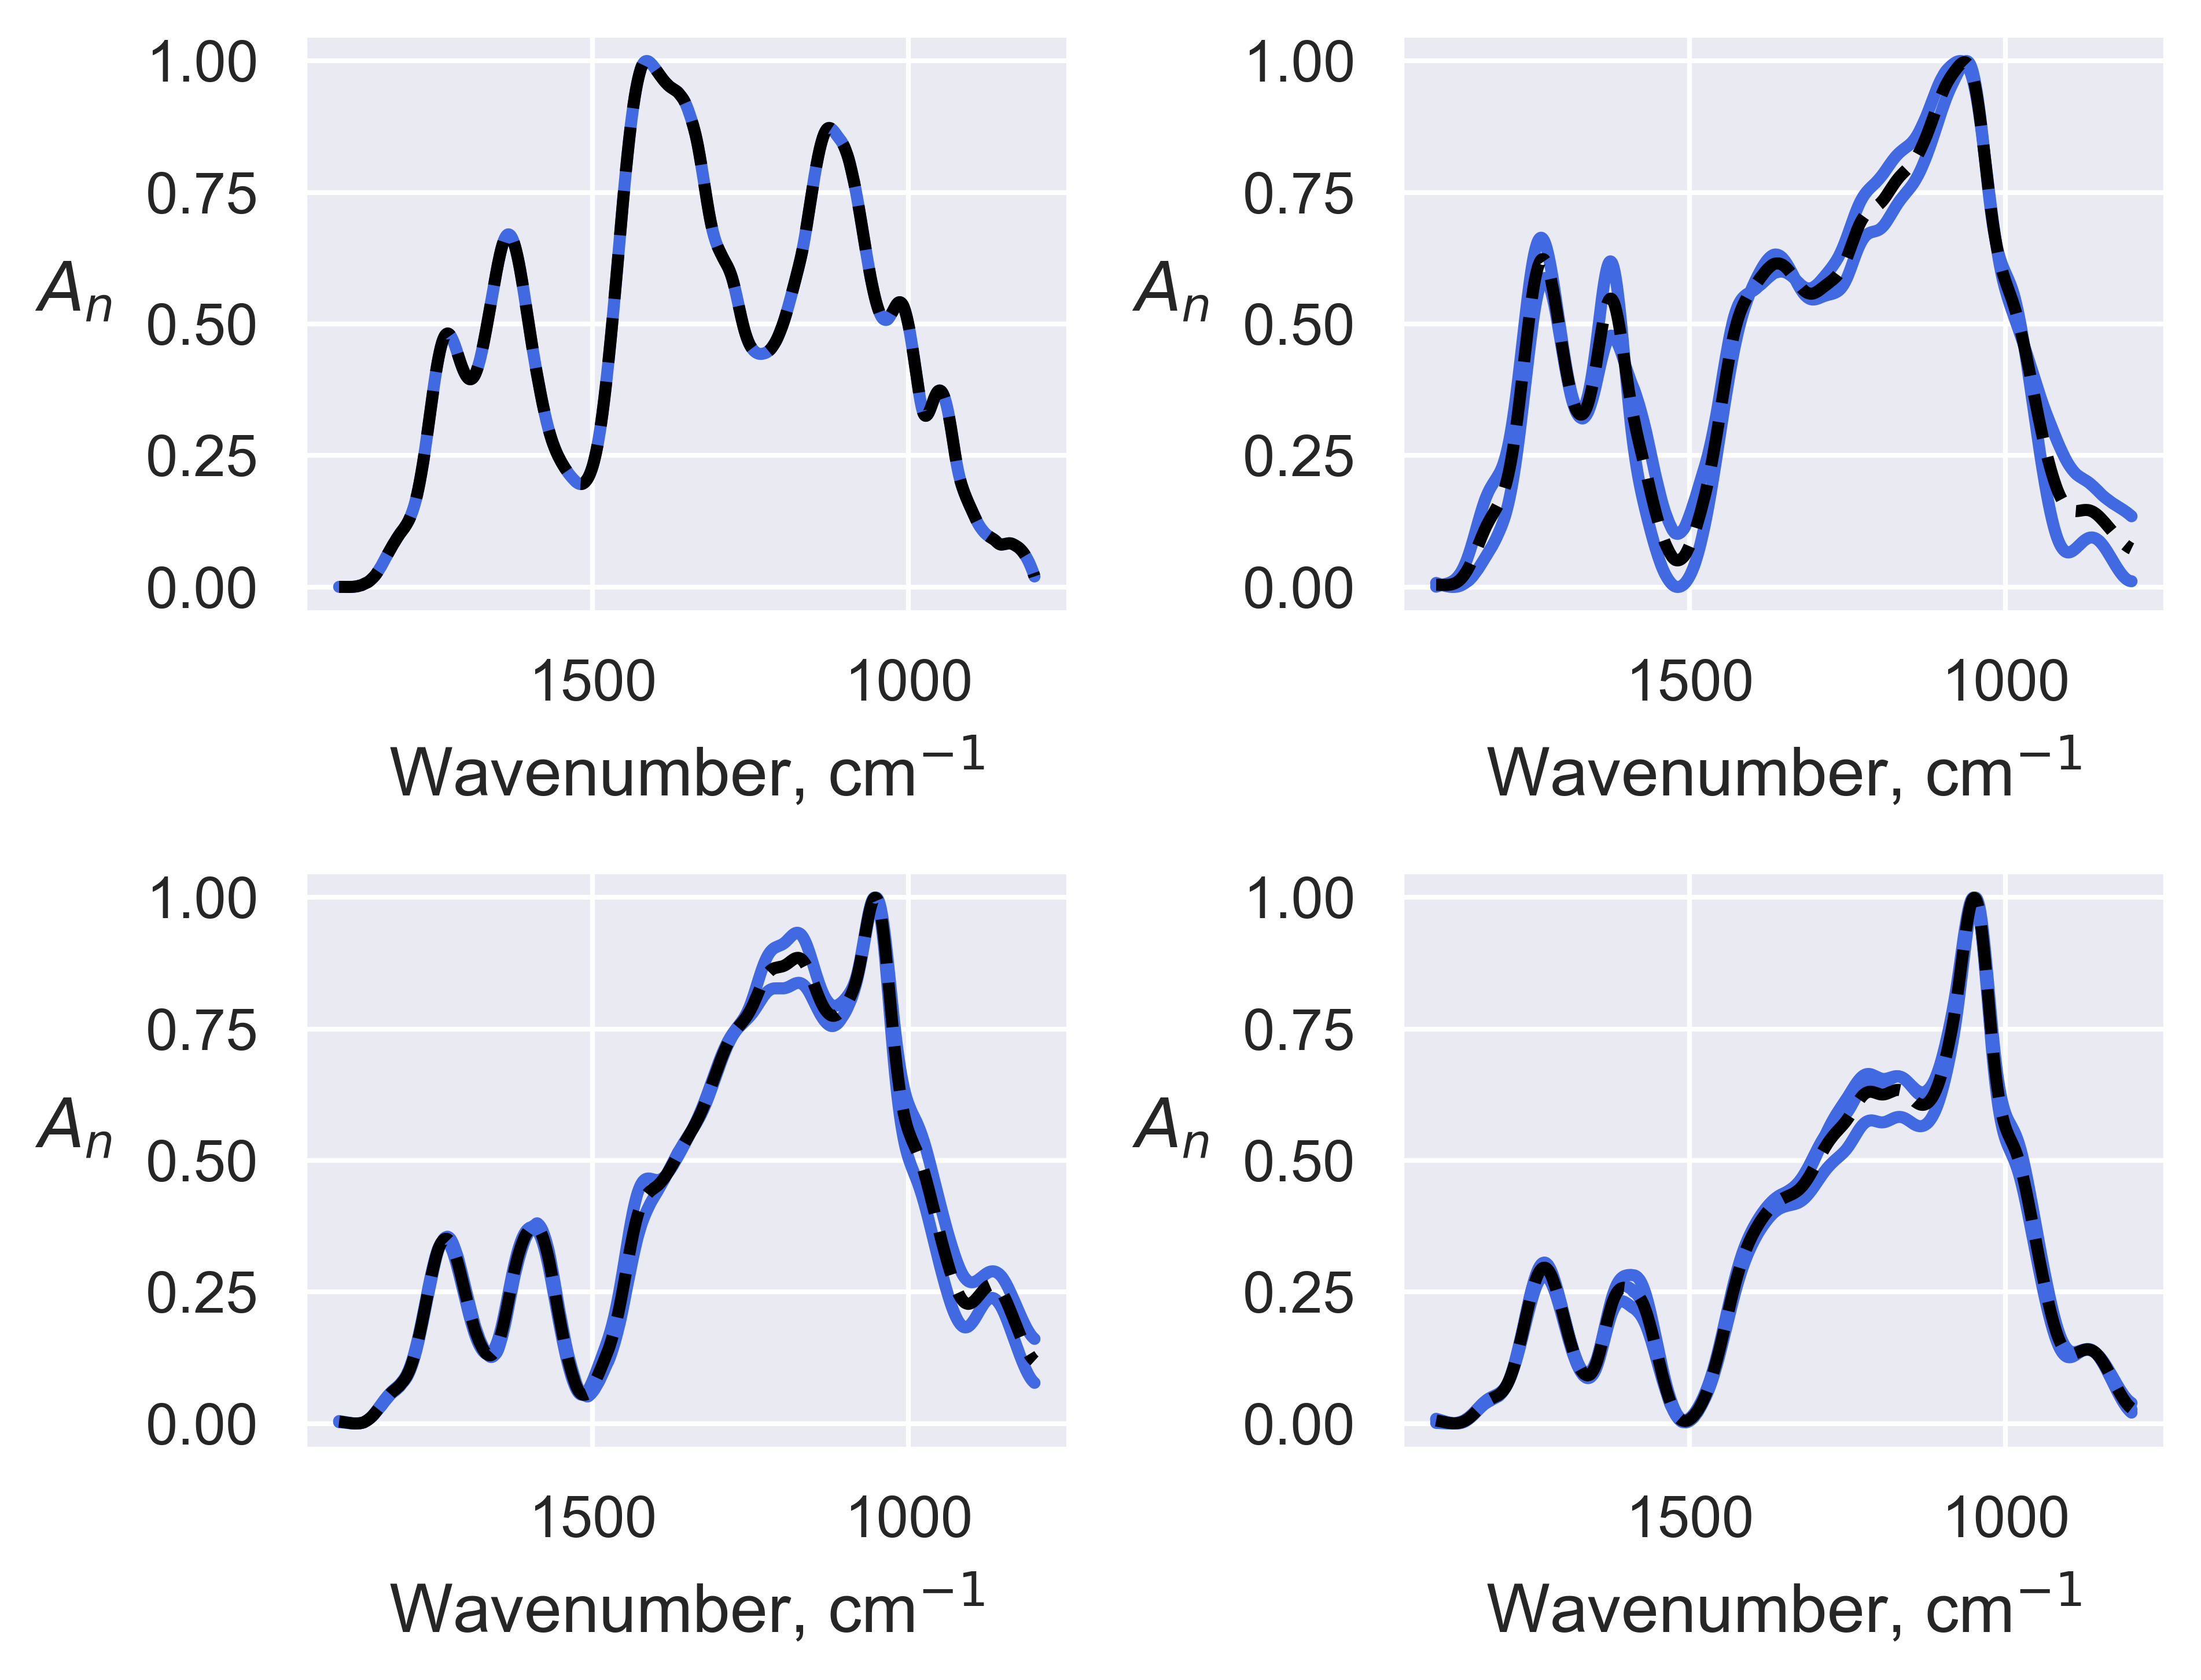

In [25]:
test_an.get_spectra_clusters_visualization(shape=(1, 4), wavenumber=wavenumber,
                                           ncols=2, nrows=2, figsize=(6.5, 5), color='RoyalBlue',
                                           path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.6889931623575868


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 28.55it/s]


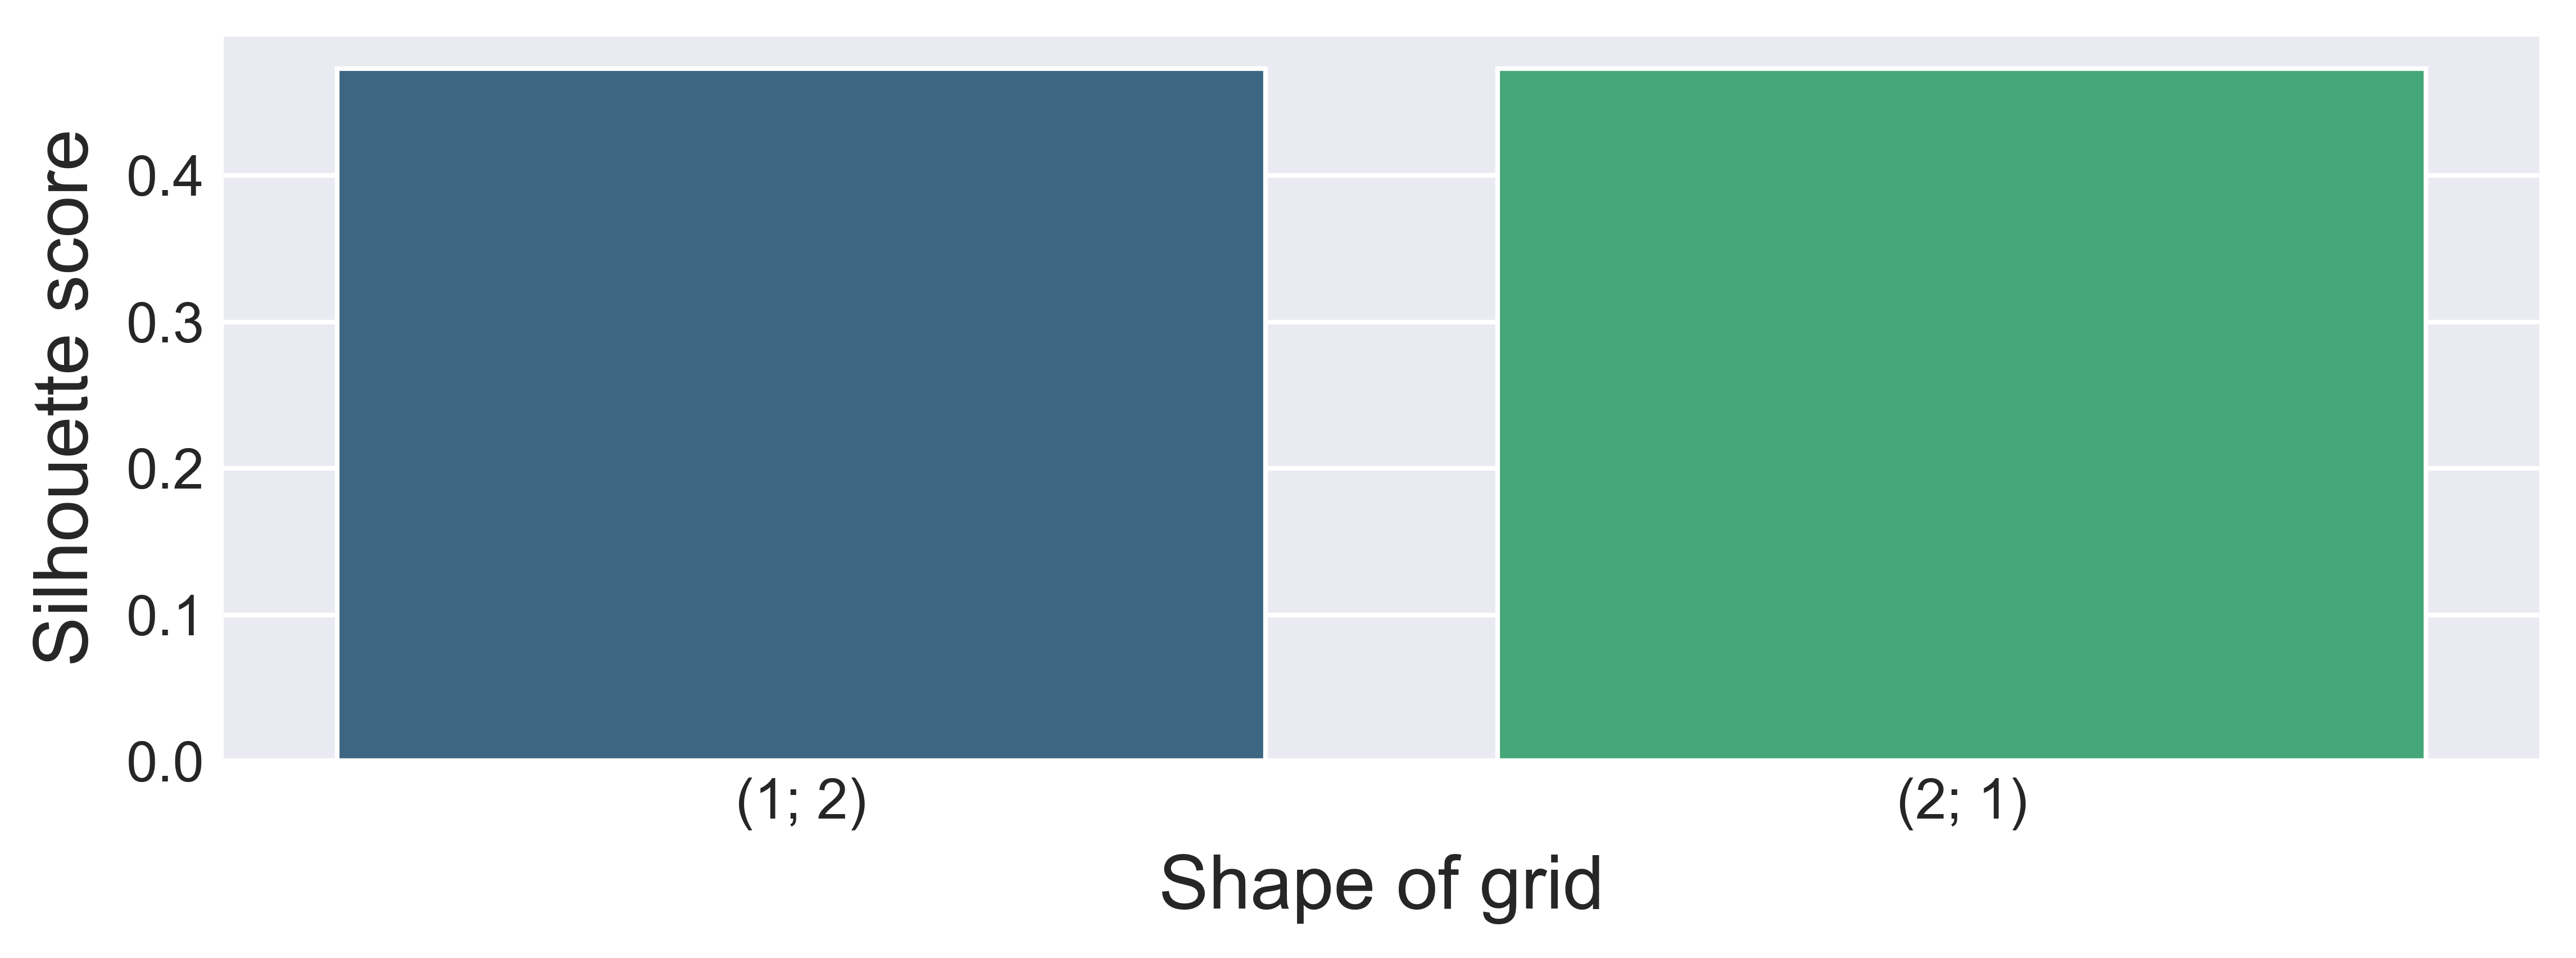

In [50]:
test_an = SomStructureAnalysis(rgo_data)
test_an.fit_transform_som(shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=1_000, random_seed=42)

test_an.get_metrics_visualization(metric='silhouette', num_iteration=1_000, figsize=(7.8, 3),
                                  path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.6889931207621527


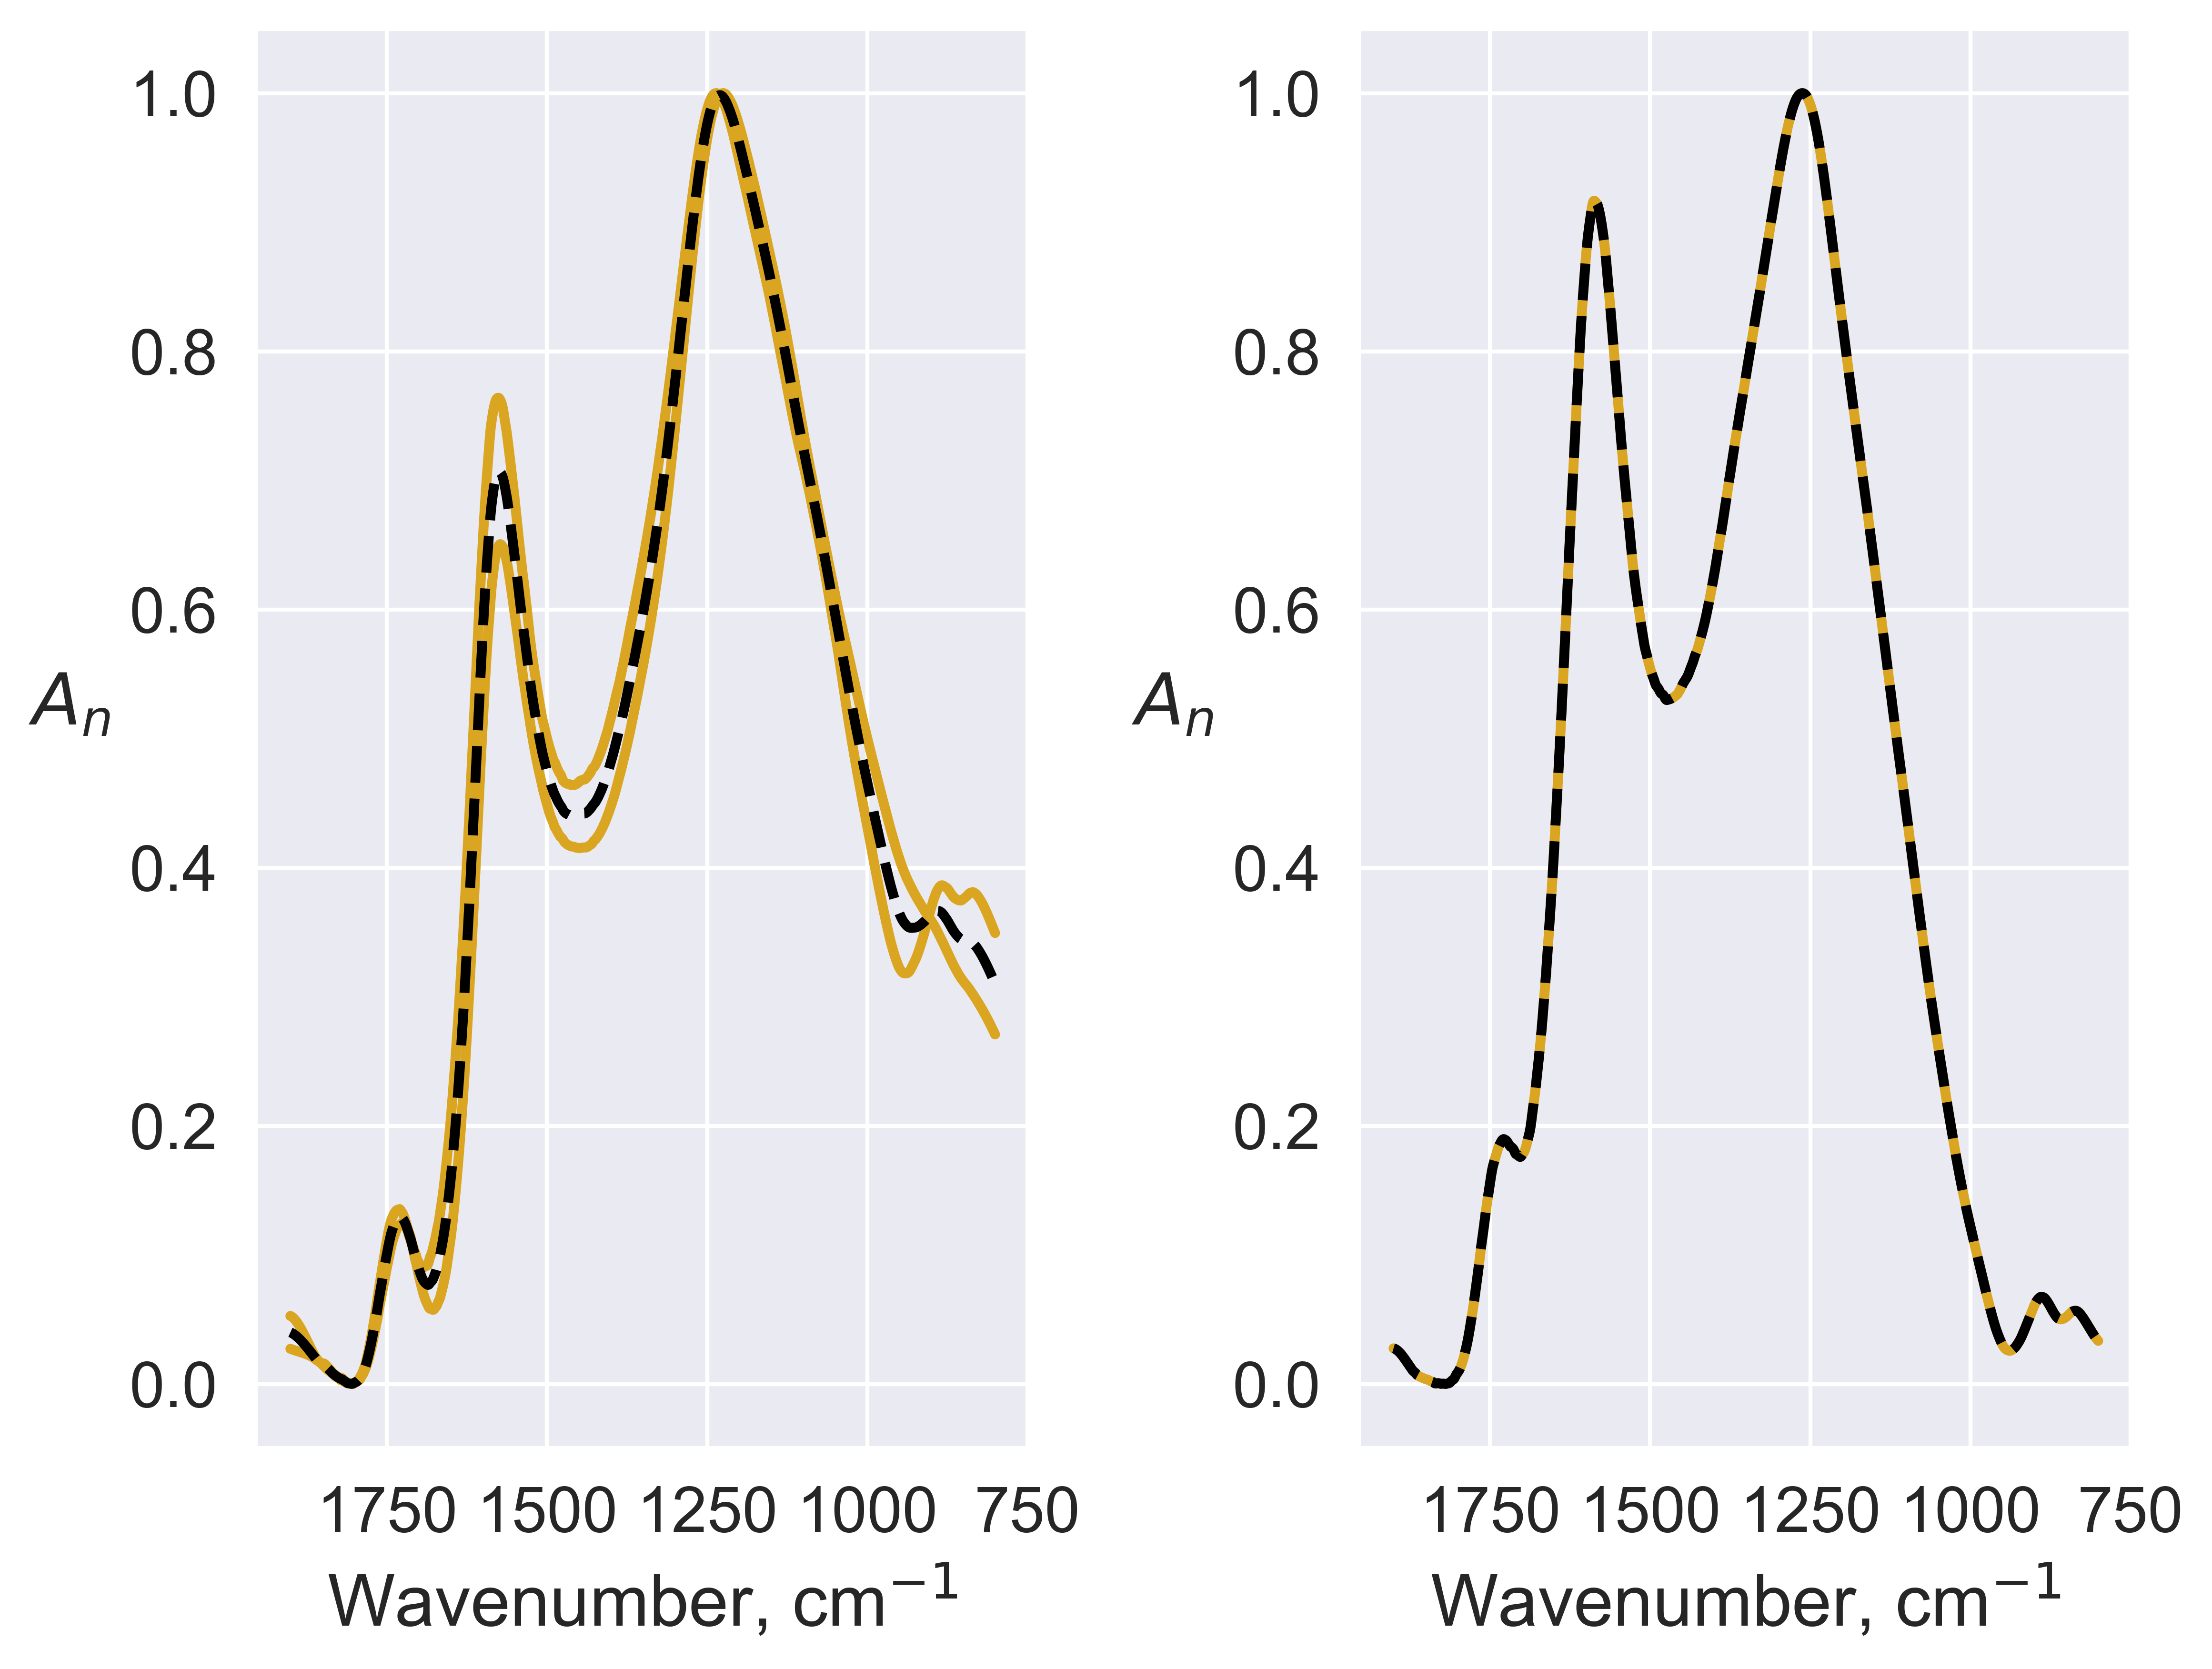

In [51]:
test_an.get_spectra_clusters_visualization(shape=(1, 2), wavenumber=wavenumber,
                                           ncols=2, nrows=1, figsize=(7.9, 6), color='Goldenrod',
                                           path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.431274428416973


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


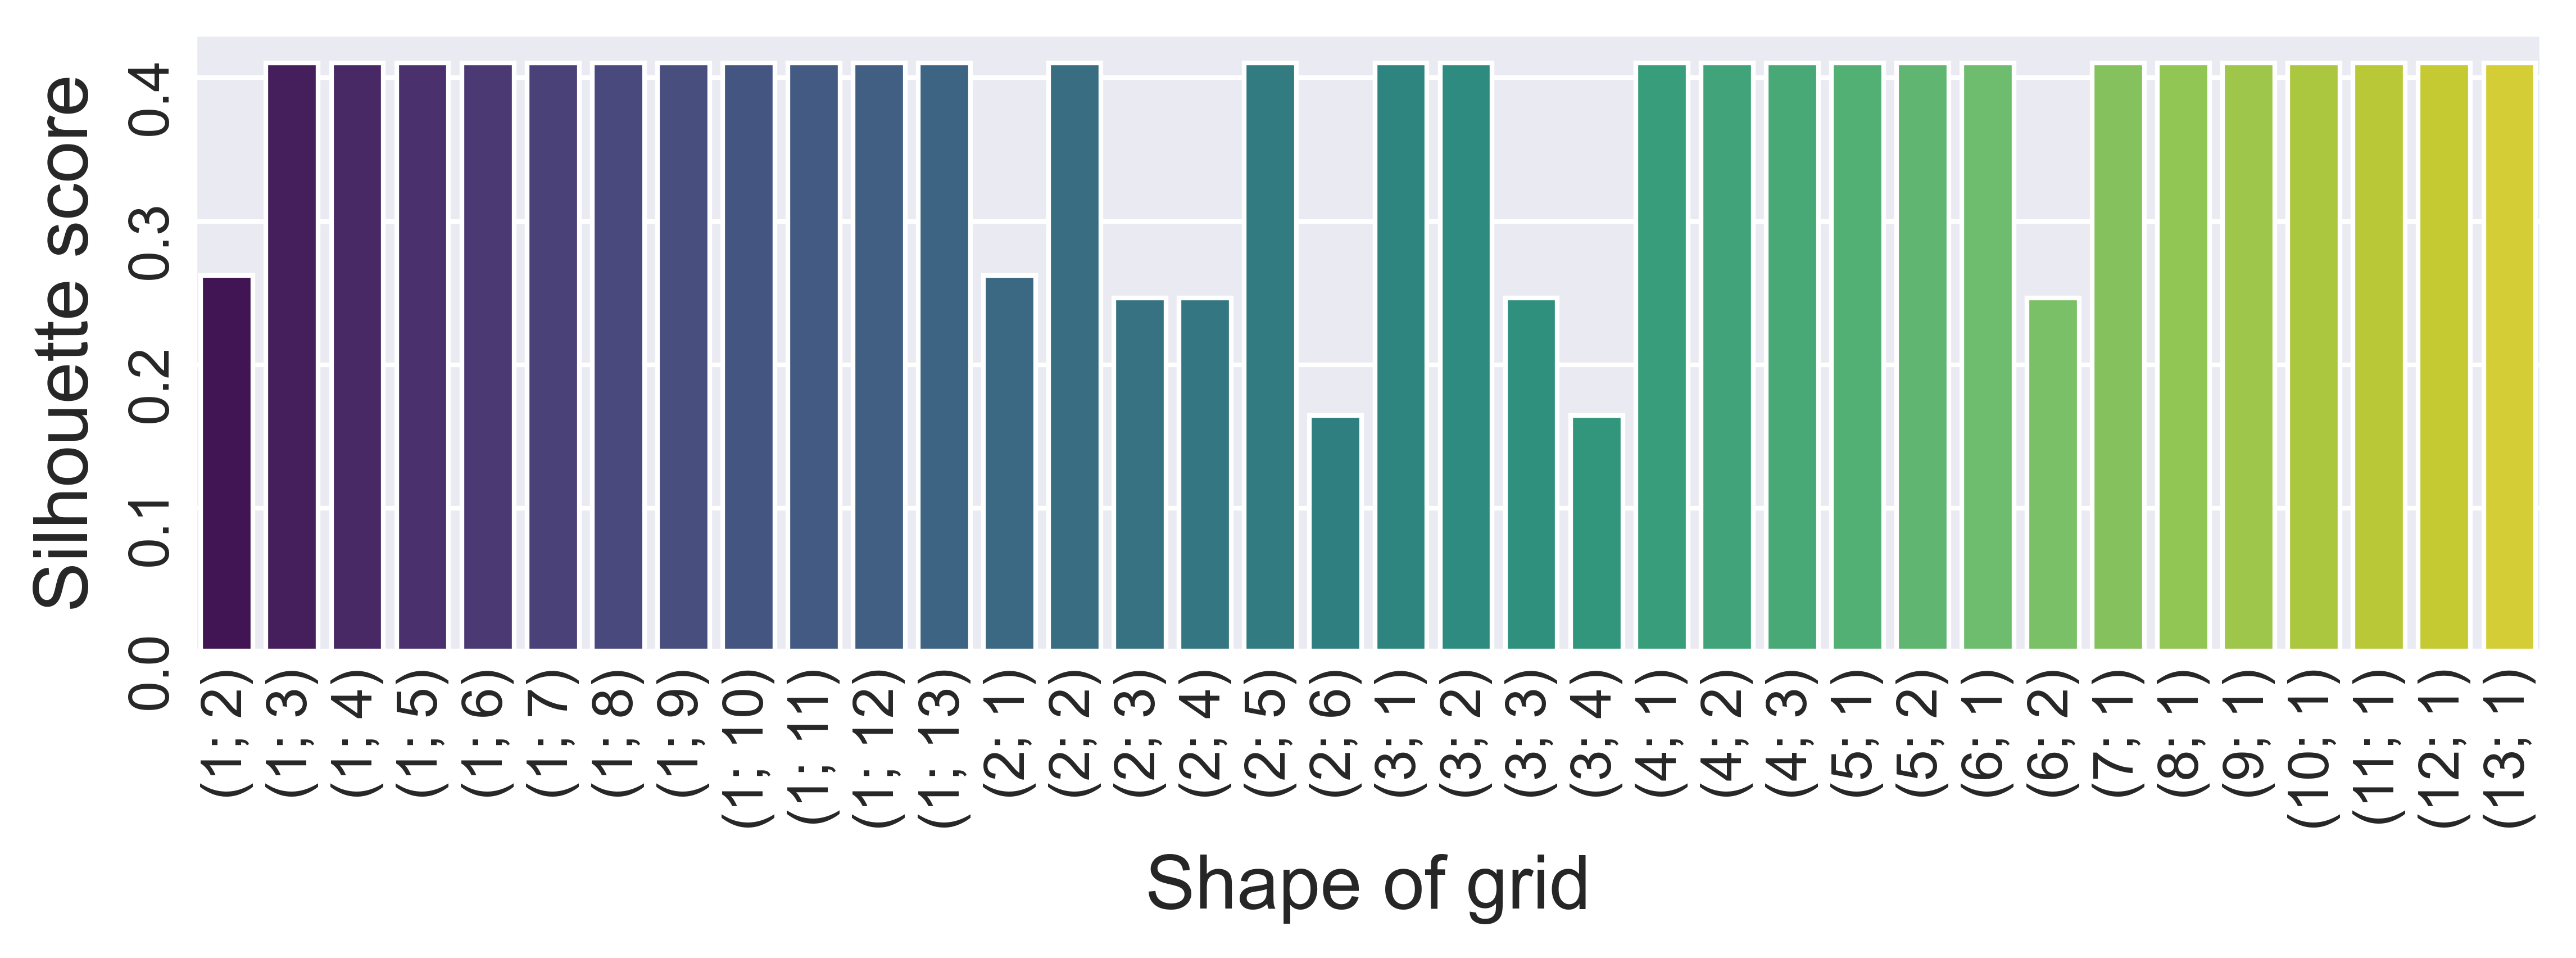

In [44]:
test_an = SomStructureAnalysis(god_data)
test_an.fit_transform_som(shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=1_000, random_seed=42)

test_an.get_metrics_visualization(metric='silhouette', num_iteration=1_000, figsize=(7.8, 3), rotation_x=90,
                                  path_to_save=path_to_save + '/god_metrics.png', dpi=600)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.4755635273492511


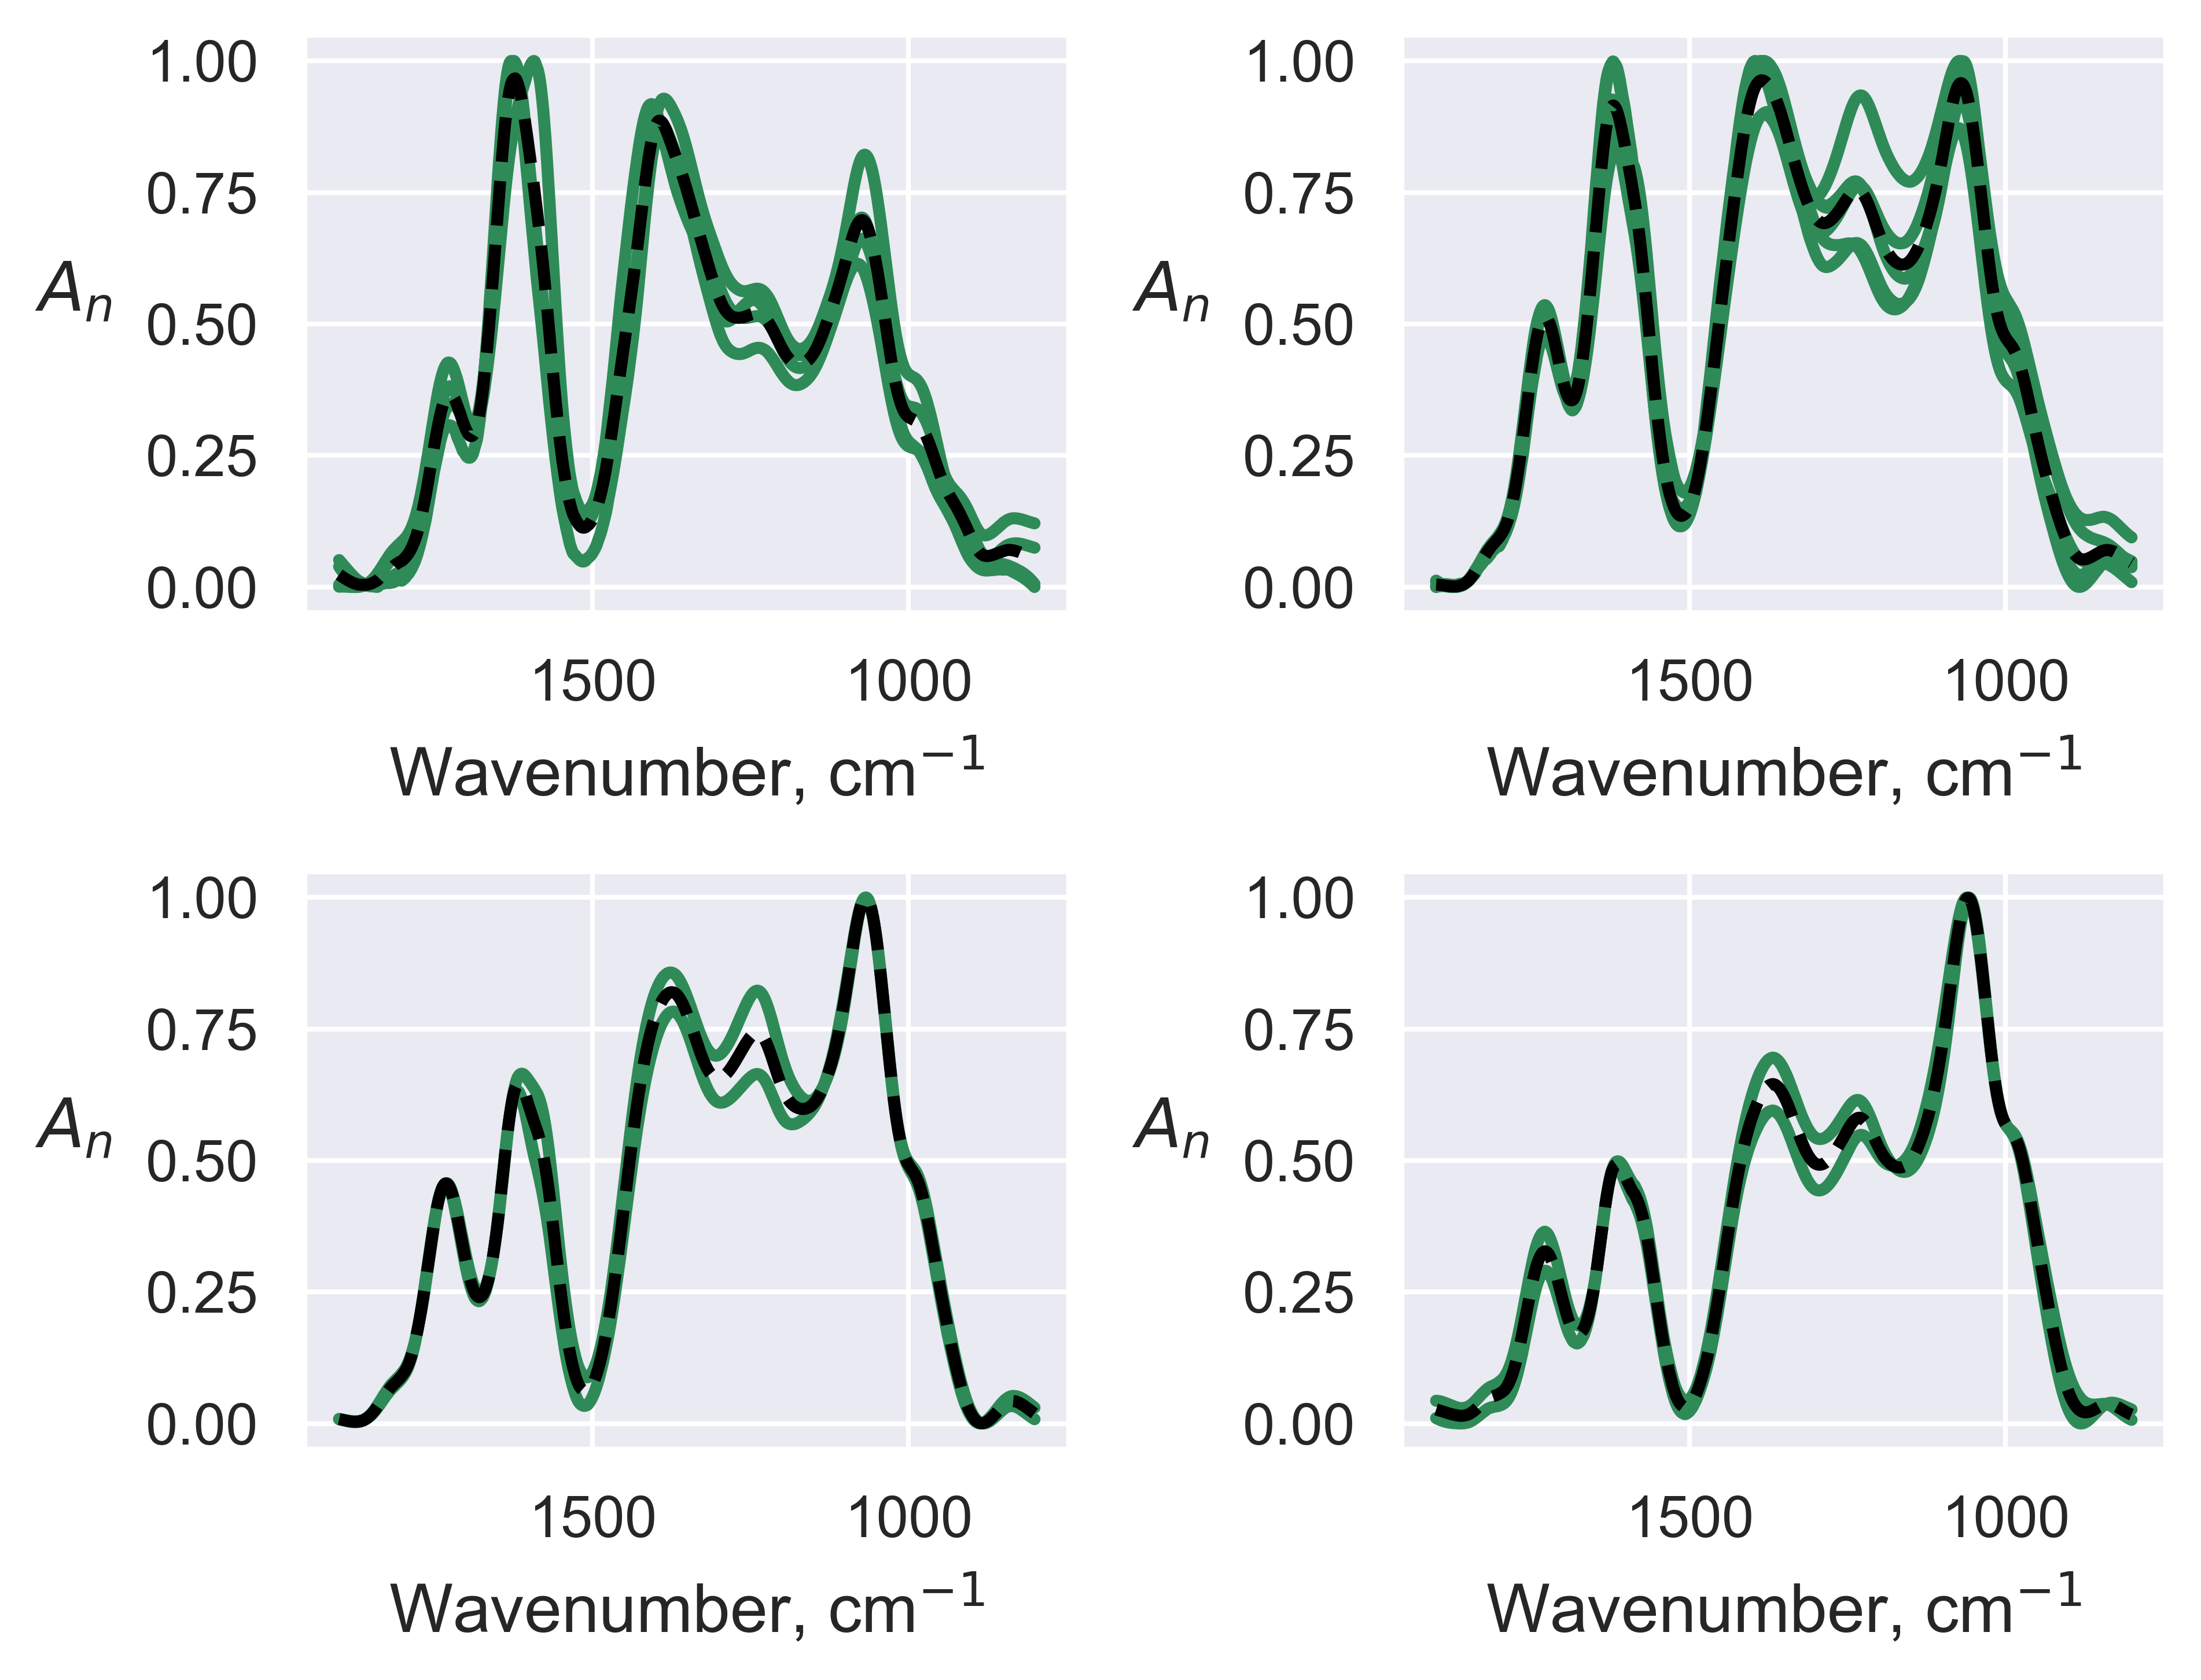

In [45]:
test_an.get_spectra_clusters_visualization(shape=(4, 1), wavenumber=wavenumber, num_iteration=5_000,
                                           ncols=2, nrows=2, figsize=(6.5, 5), color='SeaGreen',
                                           path_to_save=path_to_save + '/god_clusters.png', dpi=600)